In [130]:
import matplotlib.pyplot as plt
import scipy.io as io
import numpy as np
import copy
import pandas as pd

import os
import glob


Okay so, when I ran the code on the ~2000 images, I found that the cropping method had an error of about 10%. That is, 
of the 2000 ish images, 200 or so would not have the expected cropping behavior. So, this code goes through the process step by step, 
and compares a file that I know will be cropped propperly, and one that I know has failed. 

The goal is to see if I can identify the issue. 

In [131]:
import sys
sys.path.insert(1, '../../src')
import preprocess_filter

In [132]:
training_df = pd.read_csv('resolution_test/training_image_resolution.csv')
training_df

,opus_id,x_length,y_length,folder,full_path,pixel_error
0,W1630641951,1488,281,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,55
1,W1630637151,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,51
2,W1630646151,1488,283,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,53
3,bad_bad_W1630655751,1442,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
4,W1630639551,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,51
...,...,...,...,...,...,...
1878,W1597976395,1488,601,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,265
1879,W1598009545,1488,494,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,158
1880,W1598003695,1488,517,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,181
1881,W1598000770,1488,524,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,188


In [133]:
# grabbing the bad ones

bad_df = training_df[training_df.opus_id.str.contains('bad')]
bad_df

,opus_id,x_length,y_length,folder,full_path,pixel_error
3,bad_bad_W1630655751,1442,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
7,bad_bad_W1630673151,1408,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
8,bad_bad_W1630674951,1388,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
9,bad_bad_W1630661151,1435,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
10,bad_bad_W1630663551,1425,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
...,...,...,...,...,...,...
1114,bad_bad_W1630835909,1488,1043,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,707
1115,bad_bad_W1630868429,1488,1083,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,747
1116,bad_bad_W1630842413,1488,1065,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,729
1117,bad_bad_W1630838619,1488,1065,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,729


In [134]:
bad_df.opus_id = bad_df.opus_id.str.replace("bad_bad_", "")
bad_df

/Users/willbyrne/opt/anaconda3/envs/unet/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,opus_id,x_length,y_length,folder,full_path,pixel_error
3,W1630655751,1442,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
7,W1630673151,1408,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
8,W1630674951,1388,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
9,W1630661151,1435,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
10,W1630663551,1425,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,772
...,...,...,...,...,...,...
1114,W1630835909,1488,1043,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,707
1115,W1630868429,1488,1083,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,747
1116,W1630842413,1488,1065,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,729
1117,W1630838619,1488,1065,117_SPKMVLFHP_007,../../../data/2023_imagery/filtered/117_SPKMVL...,729


In [135]:
example_bad = bad_df.iloc[0, 0]

In [136]:
exp_path = glob.glob(f'../../data/2023_rpjb/good/*/{example_bad}*')

In [137]:
exp_path = exp_path[0]

# Imitating preprocess_filter

In [138]:
# lets compare how a good image perfroms vs how a bad image performs
idl = io.readsav(exp_path)
bad_pv = idl.rrpi
bad_pv=copy.copy(bad_pv)
bad_y, bad_x = bad_pv.shape

### Initial compare

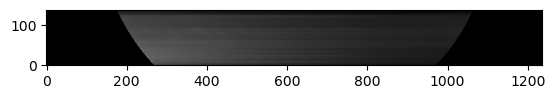

In [139]:
# pretty dark, maybe a cosmic ray?
plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

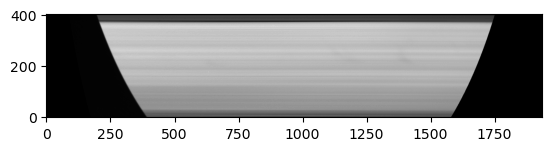

In [140]:
# example of a good image
idl = io.readsav('../../data/2023_rpjb/good/085_SPKMVLFLP/W1600545658_1_CALIB.rpjb')
good_pv = idl.rrpi
good_pv=copy.copy(good_pv)
good_y, good_x = good_pv.shape
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### Remove cosmic ray

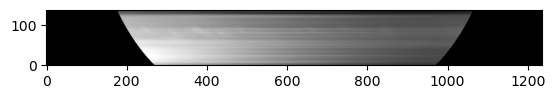

In [141]:
# Woah, so it looks like there was a cosmic ray in the image. This may have caused the cropping issue. 
bad_pv = preprocess_filter.remove_cosmic_rays(bad_pv)
plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

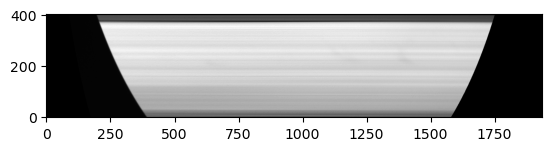

In [142]:
good_pv = preprocess_filter.remove_cosmic_rays(good_pv)
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### Quantize Prep

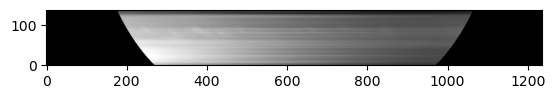

In [143]:
# again, looks fine
flt = bad_pv.flatten()
p_std = flt.std()
p_m = flt.mean()
bad_pv[bad_pv < (p_m - p_std)] = 0

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

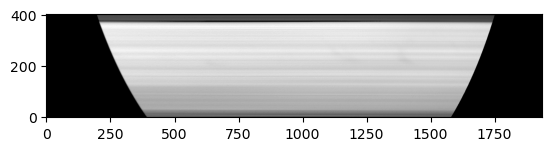

In [144]:
flt = good_pv.flatten()
p_std = flt.std()
p_m = flt.mean()
good_pv[good_pv < (p_m - p_std)] = 0

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### create quant map

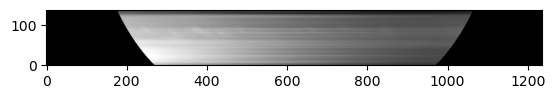

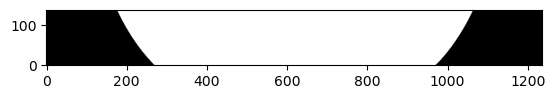

In [145]:
# so far, so good
bad_pv, bad_quant = preprocess_filter.apply_quantize(bad_pv)

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()
plt.imshow(bad_quant, cmap='gray', origin='lower')
plt.show()

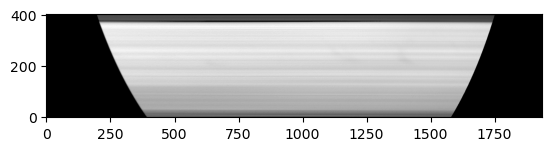

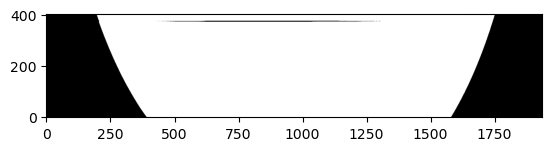

In [146]:
good_pv, good_quant = preprocess_filter.apply_quantize(good_pv)

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()
plt.imshow(good_quant, cmap='gray', origin='lower')
plt.show()

### Quant cropping

{'x_start': 261, 'x_end': 980, 'biggest_sum': 720, 'y_longst_top': 9}


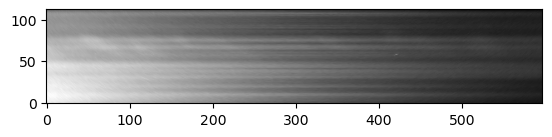

In [147]:
# it seems that the new remove cosmic ray method has solved the problem. looks, these are perfect
LS = preprocess_filter.get_quant_stats(bad_quant)
print(LS)


ybuffer = int(bad_y*.1)
xbuffer = int(bad_x*.05)
bad_pv = bad_pv[ybuffer:bad_y-ybuffer, LS["x_start"]+xbuffer:LS["x_end"]-xbuffer]

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

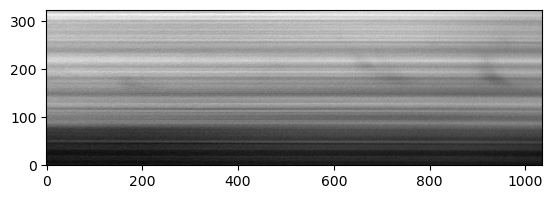

In [148]:
LS = preprocess_filter.get_quant_stats(good_quant)


ybuffer = int(good_y*.1)
xbuffer = int(good_x*.05)
good_pv = good_pv[ybuffer:good_y-ybuffer, LS["x_start"]+xbuffer:LS["x_end"]-xbuffer]

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### now, lets check out this new buffer method I wrote

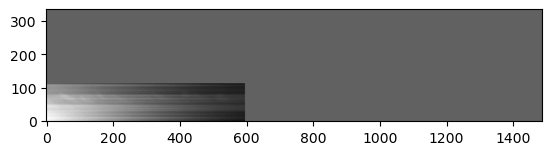

In [149]:
# Ya so uh, that doesn't look great. I will redo resolution analysis 

bad_pv = preprocess_filter.buffer_image(bad_pv, propper_x=1488, propper_y=336)
plt.imshow(bad_pv, cmap='gray', origin='lower')

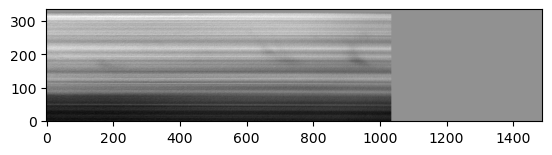

In [150]:
good_pv = preprocess_filter.buffer_image(good_pv, propper_x=1488, propper_y=336)
plt.imshow(good_pv, cmap='gray', origin='lower')

### Forrier time!

In [151]:
import sys
sys.path.insert(1, '../../../spokes_gridtools/Research2022/spokes/src')
import spoketools

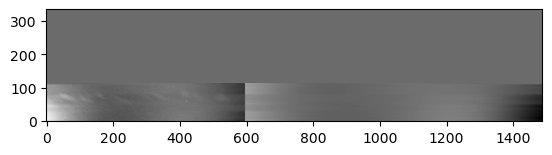

In [153]:
# Ew, this is so ugly
bad_pv = spoketools.fft2lpf(bad_pv,0, 3 )
plt.imshow(bad_pv, cmap='gray', origin='lower')

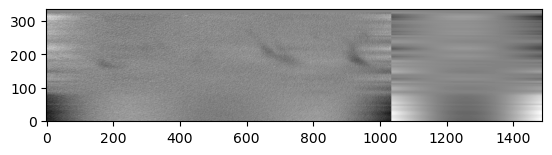

In [155]:
good_pv = spoketools.fft2lpf(good_pv, 0, 3)
plt.imshow(good_pv, cmap='gray', origin='lower')

### Lucy median filter??

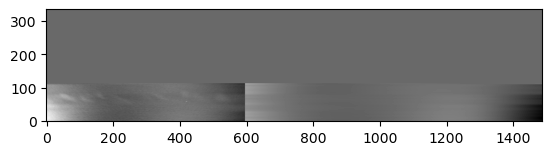

In [156]:
bad_pv = preprocess_filter.apply_lucy_median(bad_pv)
plt.imshow(bad_pv, cmap='gray', origin='lower')

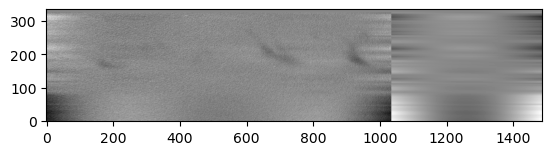

In [157]:
good_pv = preprocess_filter.apply_lucy_median(good_pv)
plt.imshow(good_pv, cmap='gray', origin='lower')

# CONCLUSION -  likely cause of the bad cropping was due to the selective removal of cosmic rays, i.e. only removing cosmic rays if they were above a certian brightness. 

#### This condition has been removed and the removal of cosmic rays has been abstracted from the Lucys median filter process. 

#### remove_cosmic_rays now replaces the top 20 brightest pixels in a row with the 21st brightest pixel for every row in an image regardless of how bight the cosmic ray is. 